In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import os
import csv 

import keras
import tensorflow as tf
from keras import backend
from keras.backend import set_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.optimizers import Adam
from keras.layers import Reshape
from keras import layers
import datetime

from keras import initializers


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory
config.gpu_options.visible_device_list = "0"

set_session(tf.compat.v1.Session(config=config))

2022-12-07 11:12:31.072673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 11:12:31.187945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:31.320125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:31.321401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
path = '/kaggle/input/face-mask-dataset-1'
xname = '/kaggle/input/face-mask-dataset-1/celebA_real_with_mask1.pickle'
yname = '/kaggle/input/face-mask-dataset-1/celebA_real_with_out_mask1.pickle'
pickle_in = open(os.path.join(path,xname),"rb")
x = pickle.load(pickle_in)

pickle_in = open(os.path.join(path,yname),"rb")
y = pickle.load(pickle_in)

print(x.shape)
print(y.shape)
print(type(x))

(10000, 128, 128, 1)
(10000, 128, 128, 1)
<class 'numpy.ndarray'>


In [3]:
fields = ["Gan Loss", "Disc loss", "Gen Loss" , "Test Gan Loss", "Test Disc Loss"]
rows = []
print(rows)

[]


(10000, 64, 64, 1)
(10000, 64, 64, 1)


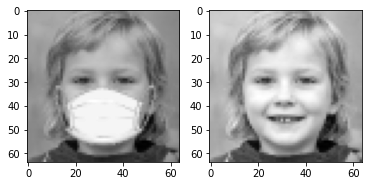

In [4]:
#Resize the image from 200 * 200 to 64 * 64

from skimage.transform import resize
x = resize(x, (len(x),64, 64,1), anti_aliasing=False)
y = resize(y, (len(y),64,64,1), anti_aliasing=False)

# Print the shape after resize
print(x.shape)
print(y.shape)

#Draw the image to be sure occluded image is the same as the ground truth one
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[4,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[4,:,:,0],cmap="gray")


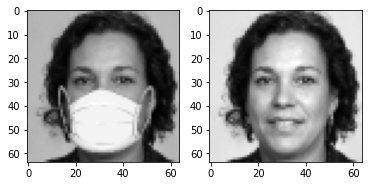

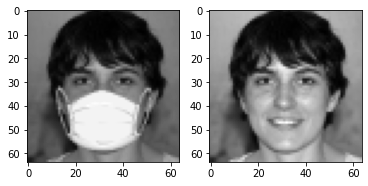

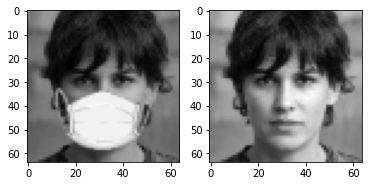

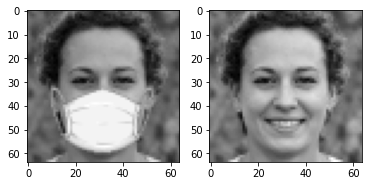

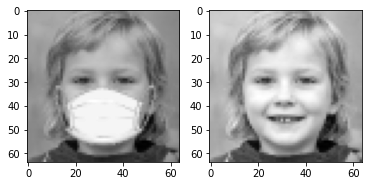

In [5]:
for i in range(5):
    fig=plt.figure(figsize=(6, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(x[i,:,:,0],cmap="gray")
    fig.add_subplot(1, 2, 2)
    plt.imshow(y[i,:,:,0],cmap="gray")

In [6]:
print(x.shape)
print(y.shape)

(10000, 64, 64, 1)
(10000, 64, 64, 1)


In [7]:
#print pixel values to be sure occluded and ground truth images are aligned
print(x[2,50:52,50:52,0])
print(y[2,50:52,50:52,0])

[[0.42843137 0.42843137]
 [0.41960784 0.42058824]]
[[0.42843137 0.42843137]
 [0.41960784 0.42058824]]


In [8]:
#Here is the function to create a generator. 
def creategen():
  generator = Sequential()


  generator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))


  generator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  
  generator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh"))
  

  return generator

generator = creategen()


2022-12-07 11:12:57.753150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:57.754119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:57.754983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:57.755671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:57.756411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
#Here is the function to create a discriminator. 
def createdisc():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))


  discriminator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Flatten())
  discriminator.add(Dense(1))
  
  return discriminator


discriminator = createdisc()


In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [11]:
# Learning rate of discriminator is advised to be the double of the generator. 
# train the generator two times in each step of training. First is with Gan loss, second is with L2 loss.
# That is why we use x4 learning rate in discriminator.

opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)      

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
opt_gen = Adam(lr=0.00002)
generator.compile(loss="mean_squared_error", optimizer = opt_gen)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [13]:
print(x[0])

[[[0.67058824]
  [0.66764706]
  [0.6754902 ]
  ...
  [0.69117647]
  [0.68235294]
  [0.68235294]]

 [[0.67058824]
  [0.67156863]
  [0.67745098]
  ...
  [0.69313725]
  [0.69215686]
  [0.6872549 ]]

 [[0.67156863]
  [0.6754902 ]
  [0.67941176]
  ...
  [0.69411765]
  [0.69509804]
  [0.69117647]]

 ...

 [[0.68627451]
  [0.68137255]
  [0.68627451]
  ...
  [0.68235294]
  [0.68431373]
  [0.68137255]]

 [[0.68823529]
  [0.68431373]
  [0.68431373]
  ...
  [0.68137255]
  [0.68137255]
  [0.6745098 ]]

 [[0.69117647]
  [0.68627451]
  [0.68137255]
  ...
  [0.52941176]
  [0.67647059]
  [0.66372549]]]


In [14]:
#Here is the function to create a GAN model.

def creategan(generator,discriminator):
  gan = Sequential()
  gan.add(generator)
  discriminator.trainable = False
  gan.add(discriminator)
  return(gan)

gan = creategan(generator,discriminator)

In [15]:
opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         2054208   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1044225   
Total params: 3,098,433
Trainable params: 2,052,928
Non-trainable params: 1,045,505
_________________________________________________________________


In [16]:
# This is to save models. It saves both the architectures and the weights.

def save_models(gan,discriminator,generator,path,epoch):
  datenow = str(datetime.datetime.now().strftime('%m-%d-%H:%M'))
  gan.save_weights(os.path.join(path,"{0}_wgan_{1}.h5".format(epoch,datenow)))
  gan.save(os.path.join(path,"{0}_mgan_{1}.h5".format(epoch,datenow)))


  discriminator.save_weights(os.path.join(path,"{0}_wd_{1}.h5".format(epoch,datenow)))
  discriminator.save(os.path.join(path,"{0}_md_{1}.h5".format(epoch,datenow)))


  generator.save_weights(os.path.join(path,"{0}_wg_{1}.h5".format(epoch,datenow)))
  generator.save(os.path.join(path,"{0}_mg_{1}.h5".format(epoch,datenow)))
  


In [17]:
def test(x,y):
  gan_inp_t = x  
  gan_label_t = np.ones([len(gan_inp_t)])
  gan_predict_t = None
  
  disc_inp_t = None


  disc_label_t = np.zeros([len(gan_inp_t)*2])
  disc_label_t[len(gan_inp_t):] = 1
  
  disc_predict_t = None
  

  gen_predict_t = generator.predict(gan_inp_t)


  disc_inp_t = np.concatenate((gen_predict_t,y), axis = 0)
  disc_predict_t = discriminator.predict(disc_inp_t)

  d_loss_t = discriminator.test_on_batch(disc_inp_t,disc_label_t)

  gan_loss_t = gan.test_on_batch(gan_inp_t,gan_label_t)
  
  return (gan_loss_t, d_loss_t)

In [18]:
# I use isolated mini batches to slow down discriminator:
# I also use smooth/noisy labels proposed by Salimans et al 2016
# Reference: https://github.com/soumith/ganhacks



def train(x,y, nepoch, model_save_path = "./"):

  gen_predict = None
  
  #Initialize the inputs and the labels.
  gan_inp = x 
  gan_inp_size = 64
  gan_label = np.ones(64)
  gan_predict = None
  
  disc_inp = None


  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  

  sess = tf.compat.v1.Session()

  
  
  for epoch in range(nepoch):

    for batch_ctr in range(125):

      #Generator makes a prediction.
      gen_predict = generator.predict(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size])
    

      #Minibatch isolation and label smoothing is done here:
      
      if(epoch%2==0):
        disc_inp = gen_predict
        #disc_label = np.zeros(64) //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=0, scale=0.10, size=64)
      else:
        disc_inp = y[batch_ctr*64:(batch_ctr+1)*64]
        #disc_label = np.ones(64)  //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=1, scale=0.10, size=64)


        
      #Initialize a label variable for generator to use it in training.  
      gen_label = y[batch_ctr*64:(batch_ctr+1)*64]
      
      
      #Do one training step. Also assign the losses to variables. We will print them.
      d_loss = discriminator.train_on_batch(disc_inp,disc_label)


      gan_loss = gan.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],
                                    gan_label)

      gen_loss = generator.train_on_batch(gan_inp[batch_ctr*gan_inp_size:(batch_ctr+1)*gan_inp_size],gen_label)
      
    
    
    if epoch == nepoch - 1:
      save_models(gan,discriminator,generator, model_save_path,epoch+1)  
      print("MODEL SAVED")
      
    
    # Test images are the images after the 4160th image. It makes 311 test images.
    (tgan,tdisc)= test(x[8000:9000],y[8000:9000])
    
    rows.append([gan_loss,d_loss,gen_loss,tgan,tdisc])
    print("Epoch: {2} Gan Loss: {0}       Disc Loss: {1}        Gen Loss: {3}".format(gan_loss,d_loss,epoch+1,gen_loss))
    print("Epoch: {2} Test Gan Loss: {0}  Test Disc Loss: {1} \n\n\n".format(tgan,tdisc,epoch+1))

In [19]:
# Checking lengths of the input and ground truth arrays. Also checking if normalization is done.
print(len(x),len(y))
print(x.max(),x.min())
print(y.max(),y.min())

10000 10000
1.0 0.0
1.0 0.0


In [20]:
# model_path = "/kaggle/input/weight-4400-epochs"

# epoch = 300

# # #generator = creategen()
# generator.load_weights(os.path.join(model_path,"{0}_wg_11-29-09_24.h5".format(epoch)))
# # #discriminator = createdisc()
# discriminator.load_weights(os.path.join(model_path,"{0}_wd_11-29-09_24.h5".format(epoch)))

# # #gan = creategan(generator,discriminator)
# gan.load_weights(os.path.join(model_path,"{0}_wgan_11-29-09_24.h5".format(epoch)))

# print("4400 epochs weight loaded")

In [21]:

model_save_path = './'
batch_size = 64
train(x,y, 250 ,model_save_path)


2022-12-07 11:12:59.841742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:59.843106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:59.844792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:59.846002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 11:12:59.847098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch: 1 Gan Loss: 15.424948692321777       Disc Loss: 0.43223220109939575        Gen Loss: 0.14523915946483612
Epoch: 1 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch: 2 Gan Loss: 0.057950206100940704       Disc Loss: -0.05782760679721832        Gen Loss: 0.07677087187767029
Epoch: 2 Test Gan Loss: 3.3430820622015744e-05  Test Disc Loss: 7.613903045654297 



Epoch: 3 Gan Loss: 15.424948692321777       Disc Loss: 0.2447512149810791        Gen Loss: 0.039012327790260315
Epoch: 3 Test Gan Loss: 15.424948692321777  Test Disc Loss: 0.7021976113319397 



Epoch: 4 Gan Loss: 1.1511973142623901       Disc Loss: 0.2791091799736023        Gen Loss: 0.02149229310452938
Epoch: 4 Test Gan Loss: 0.0048263599164783955  Test Disc Loss: 7.453569412231445 



Epoch: 5 Gan Loss: 15.424948692321777       Disc Loss: 0.2770841121673584        Gen Loss: 0.014352437108755112
Epoch: 5 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.705830097198486 



Epoch: 6 Gan Loss: 0

2022-12-07 12:27:13.133907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Epoch: 208 Gan Loss: 15.424948692321777       Disc Loss: 15.696574211120605        Gen Loss: 0.0023763561621308327
Epoch: 208 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch: 209 Gan Loss: 15.424948692321777       Disc Loss: -0.3215515613555908        Gen Loss: 0.0023728040978312492
Epoch: 209 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch: 210 Gan Loss: 15.424948692321777       Disc Loss: 15.337064743041992        Gen Loss: 0.0023749570827931166
Epoch: 210 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch: 211 Gan Loss: 15.424948692321777       Disc Loss: 0.4580364525318146        Gen Loss: 0.002398919081315398
Epoch: 211 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch: 212 Gan Loss: 15.424948692321777       Disc Loss: 15.31180477142334        Gen Loss: 0.0023715877905488014
Epoch: 212 Test Gan Loss: 15.424948692321777  Test Disc Loss: 7.712474822998047 



Epoch:

In [22]:
filename = "loss.csv"
     
with open(filename, 'w', newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
        
    csvwriter.writerow(fields) 
        
    csvwriter.writerows(rows)

In [23]:
model_path = "/kaggle/input/weight"

epoch = 500

# #generator = creategen()
generator.load_weights(os.path.join(model_path,"{0}_wg_12-03-22_37.h5".format(epoch)))
# #discriminator = createdisc()
discriminator.load_weights(os.path.join(model_path,"{0}_wd_12-03-22_37.h5".format(epoch)))

# #gan = creategan(generator,discriminator)
gan.load_weights(os.path.join(model_path,"{0}_wgan_12-03-22_37.h5".format(epoch)))


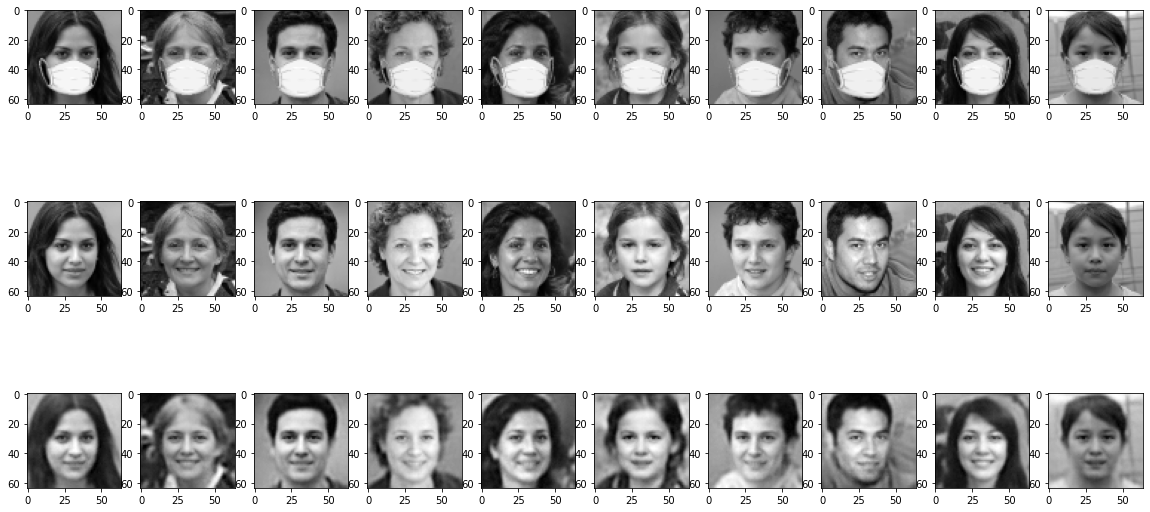

In [24]:
# Making predictions and drawing them.
# First row: Occluded images
# Second row: Ground Truth images
# Third row: Predictions

import datetime
plot_path = "./"

a = 6950
b = 6960
pred=generator.predict(x[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(x[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(y[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
plt.savefig(os.path.join(plot_path,str(datetime.datetime.now().strftime('%m-%d-%H:%M'))))

In [25]:
# import pandas as pd
# from matplotlib import pyplot as plt

# figure, axis = plt.subplots(1, 2)

# columns = ["Epochs", "GanLoss"]

# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.GanLoss)
# axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'GanLoss')
# axis[0].set_title('6050 epoch GAN Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.GanLoss)
# axis.flat[1].set(xlabel = 'Epochs' , ylabel = 'GanLoss')

# axis[1].set_title('6050 epoch GAN Loss')

In [26]:

# figure, axis = plt.subplots(1, 2)

# columns = ["Epochs", "GenLoss"]
# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.GenLoss)
# axis.flat[0].set(xlabel = 'Epoch' , ylabel = 'GenLoss')
# axis[0].set_title('6050 epoch Gen Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.GenLoss)
# axis.flat[1].set(xlabel = 'Epoch' , ylabel = 'GenLoss')

# axis[1].set_title('6050 epoch Gen Loss')

In [27]:

# figure, axis = plt.subplots(1, 2)
# columns = ["Epochs", "DiscLoss"]
# df = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[0].plot(df.Epochs, df.DiscLoss)
# axis.flat[0].set(xlabel = 'Epochs' , ylabel = 'DiscLoss')
# axis[0].set_title('6050 epoch Disc Loss')

# df1 = pd.read_csv('../input/loss-6050/loss.csv', usecols=columns)
# axis[1].plot(df1.Epochs, df1.DiscLoss)
# axis.flat[1].set(xlabel = 'Epoch' , ylabel = 'DiscLoss')

# axis[1].set_title('6050 epoch Disc Loss')

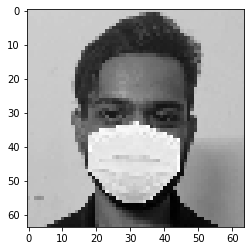

In [28]:
import cv2
import matplotlib.image as mpimg
img = mpimg.imread("/kaggle/input/vijay-2000/Monishh_surgical.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img.shape
plt.imshow(img)
from skimage.transform import resize

img = resize(img, (64 , 64), anti_aliasing=False)
plt.imshow(img , cmap = 'gray')

In [29]:
import datetime
plot_path = "./"
img = np.expand_dims(img, axis=-1)
print(img.shape)

(64, 64, 1)


(1, 64, 64, 1)
(1, 64, 64, 1)


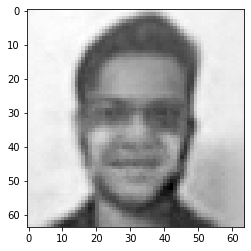

In [30]:
img = np.expand_dims(img, axis=0)
print(img.shape)
pred = generator.predict(img)
print(pred.shape)
plt.imshow(np.reshape(pred, (64,64)), cmap = "gray")

In [31]:
y=generator.predict(x[0:1])

In [32]:
# import numpy
# from numpy import cov
# from numpy import trace
# from numpy import iscomplexobj
# from numpy import asarray
# from numpy.random import randint
# from scipy.linalg import sqrtm
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.datasets.mnist import load_data
# from skimage.transform import resize
# cl = ["imageno","value"]
# val = []
# imageno=[]
# value=[]
 
# # scale an array of images to a new size
# def scale_images(images, new_shape):
#  images_list = list()
#  for image in images:
#  # resize with nearest neighbor interpolation
#      new_image = resize(image, new_shape, 0)
#      # store
#      images_list.append(new_image)
#  return asarray(images_list)
 
# # calculate frechet inception distance
# def calculate_fid(model, images1, images2):
#  # calculate activations
#  act1 = model.predict(images1)
#  act2 = model.predict(images2)
#  # calculate mean and covariance statistics
#  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
#  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
#  # calculate sum squared difference between means
#  ssdiff = numpy.sum((mu1 - mu2)**2.0)
#  # calculate sqrt of product between cov
#  covmean = sqrtm(sigma1.dot(sigma2))
#  # check and correct imaginary numbers from sqrt
#  if iscomplexobj(covmean):
#      covmean = covmean.real
#  # calculate score
#      fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
#  return fid
 
# # prepare the inception v3 model
# model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# # define two fake collections of images
# for i in range(5550,5651):
#     images1=x[i];
#     images2=generator.predict(x[i:i+1])
#     #images1 = x[5001]
#     images1 = resize(images1, (64 , 64), anti_aliasing=False)
#     #images1 = images1.reshape((10,32,32,3))
#     #images2 = generator.predict(x[5001:5002])
#     #images2 = resize(images2, (64 , 64), anti_aliasing=False)
#     #images2 = images2.reshape((10,32,32,3))
#     #print('Prepared', images1.shape, images2.shape)
#     # convert integer to floating point values
#     images1 = images1.astype('float32')
#     images2 = images2.astype('float32')
#     # resize images
#     images1 = scale_images(images1, (299,299,3))
#     images2 = scale_images(images2, (299,299,3))
#     #print('Scaled', images1.shape, images2.shape)
#     # pre-process images
#     images1 = preprocess_input(images1)
#     images2 = preprocess_input(images2)
#     # fid between images1 and images1
#     #fid = calculate_fid(model, images1, images1)
#     #print('FID (same): %.3f' % fid)
#     # fid between images1 and images2
#     fid = calculate_fid(model,images1,images2)
#     print('FID (different): %.3f' % fid)
#     imageno.append(i)
#     value.append(fid)
# val.append([imageno,value])
    
# filename = "validate.csv"

# with open(filename, 'w', newline='') as csvfile: 
#     csvwriter = csv.writer(csvfile) 

#     csvwriter.writerow(cl) 

#     csvwriter.writerows(val)

In [33]:
# val.append([imageno,value])
    
# filename = "validate.csv"

# with open(filename, 'w', newline='') as csvfile: 
#     csvwriter = csv.writer(csvfile) 

#     csvwriter.writerow(cl) 

#     csvwriter.writerows(val)

In [34]:
# import pandas
 
# # reading the CSV file
# csvFile = pandas.read_csv('/kaggle/working/validate.csv')
 
# # displaying the contents of the CSV file
# print(csvFile)